# Hashtag Analysis and relationship with MMR graph data

In [1]:
import snap
from snap import TUNGraph
import os
import sys
import operator
import pandas as pd
import subprocess
import numpy as np
import csv
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
from __future__ import print_function
from IPython.display import HTML, display
import tabulate
import json
import datetime
from datetime import timedelta
from collections import Counter
import re

# Set Seaborn defaults
sns.set()
%matplotlib inline
pd.set_option("display.precision", 3)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.autolayout'] = True

# Global variables
data_dir = "../data"
pictures_path = os.path.join("../Pictures", "6.HashtagAnalysis")
tweets_path = "../lib/GetOldTweets-python/out/completed"

In [2]:
hashtag = "jesuischarlie"
hashtag_full = "#JeSuisCharlie"

In [2]:
'''# Import the biggest connected component to work on
FIn = snap.TFIn("../data/mmr_max_connected_component.bin")
graph = snap.TUNGraph.Load(FIn)'''

In [3]:
# %load ../scripts/def_get_multiple_usernames.py
def get_multiple_usernames(ids):
    # Convert ID to line number by adding 1
    arg = ";".join([str(el + 1) + "p" for el in ids])

    #Invoke shell script that finds the occurrences
    p = subprocess.Popen(['../scripts/get_usernames.sh', arg], stdout=subprocess.PIPE)
    output = p.communicate()[0]

    id_to_username_dict = {line.split(',')[1]:line.split(',')[0] for line in output.split('\n') if line != ""}
    return id_to_username_dict

In [31]:
def cast_df_to_original_types(df, columns, df_types_dict):
    for column in columns:
        df[column] = df[column].astype(df_types_dict[column])

In [331]:
def read_large_file(file_object):
    while True:
        data = file_object.readline()
        if not data:
            break
        yield data.rstrip('\n')

## Read Tweets from file

In [333]:
%%time
tweets_filename = os.path.join(tweets_path,"tweets_#" + hashtag + "_2013-09-01_2016-12-31.json")
tweets = []
with open(tweets_filename) as fin:
    for line in read_large_file(fin):
        tweets.append(json.loads(line))
print("Imported %d tweets from %s" %(len(tweets),tweets_filename))

Imported 413857 tweets from ../lib/GetOldTweets-python/out/completed/tweets_#jesuischarlie_2013-09-01_2016-12-31.json
CPU times: user 10.3 s, sys: 252 ms, total: 10.6 s
Wall time: 10.5 s


Given the main graph, I have to identify the subgraph of nodes (usernames) that have been part of a Twitter conversation that involved the concerned hashtag. This means that I would consider node $i$ part of the subnet if one of the following occurs:
- $i$ has **tweeted** using hashtag $h$;
- $i$ has been **mentioned**/**replied to** by someone that used hashtag $h$;
- $i$ has tweeted a status that has been **retweeted**/**quoted** by someone else that used hashtag $h.$

Of course this operation is not immediate and trivial, since the usernames will be collected first as a set of actual Twitter screen names, which have to be mapped to their specific encoding afterwards. As a first example, I'm going to carry out the analysis by considering a single hashtag, then I'll extend the same analysis to multiple hashtags.

**#JeSuisCharlie** refers to the Charlie Hebdo shooting in France occurred on January 7th 2015, and by extension, a supporter of freedom of speech and resistance to armed threats. Some journalists embraced the expression as a rallying cry for the freedom of self-expression.

# 1. Extract Hashtag Subgraph
Let's collect all the usernames from the downloaded tweets and keep only the ones that are part of our MMR data.

In [4]:
def get_usernames_from_basic_tweet_info(hashtag, tweet):
    usernames = set()
    # (1): Has tweeted using hashtag
    if hashtag in [h.lower() for h in tweet["entities"]["hashtags"]]:
        usernames.add(tweet["user"]["screen_name"].lower())

    # (2): Has been mentioned / replied to
    if not tweet["in_reply_to_screen_name"] is None:
        usernames.add(tweet["in_reply_to_screen_name"].lower())
    for mentions in tweet["entities"]["user_mentions"]:
        usernames.add(mentions["screen_name"].lower())
    return usernames

def extract_hashtag_usernames(hashtag, tweets):
    hashtag_usernames = set()
    for tweet in tweets:
        hashtag_usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet))
   
        # (3): Retweeted / Quoted status
        if "retweeted_status" in tweet:
            hashtag_usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet["retweeted_status"]))
        if "quoted_status" in tweet:
            hashtag_usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet["quoted_status"]))
    print("Total unique usernames involved in '#%s' hashtag conversations from %d tweets: %d" %(hashtag, len(tweets), len(hashtag_usernames)))
    return hashtag_usernames

In [335]:
hashtag_usernames = extract_hashtag_usernames(hashtag, tweets)

Total unique usernames involved in '#jesuischarlie' hashtag conversations from 413857 tweets: 224646


Let's now find the corresponding encoding for the usernames existing in the MMR graph data:

In [336]:
%%time
# First load all usernames in memory
usernames_to_id_dict = {}
with open("../data/usernames.csv") as usernames_f:
    for line in read_large_file(usernames_f):
        username = line.split(',')[0]
        encoding = int(line.split(',')[1])
        usernames_to_id_dict[username] = encoding

CPU times: user 2min 50s, sys: 5.28 s, total: 2min 55s
Wall time: 2min 55s


In [337]:
%%time
# Filter usernames
usernames_to_id_dict = { k:v for k,v in usernames_to_id_dict.iteritems() if k in hashtag_usernames }

CPU times: user 45.3 s, sys: 648 ms, total: 45.9 s
Wall time: 45.5 s


At this point, all the values of the `usernames_to_id_dict` represent node IDs in the MMR graph so it's trivial to extract the subnet of nodes having some IDs:

In [338]:
# Get subgraph
NIdV = snap.TIntV()
for node_id in usernames_to_id_dict.itervalues():
    NIdV.Add(node_id)
hashtag_subgraph = snap.GetSubGraph(graph, NIdV)

Let's show some summary statistics:

In [339]:
tab_format = "{0: <65} {1}"
print(tab_format.format("Total Tweets for hashtag '%s': " %hashtag, len(tweets)))
print(tab_format.format("Total unique usernames found in tweets: ", len(hashtag_usernames)))
print(tab_format.format("Total usernames within ORIGINAL MMR data: ", str(len(usernames_to_id_dict)) + " (%2.f%% of %d)" %(len(usernames_to_id_dict)*100.0/len(hashtag_usernames), len(hashtag_usernames))))
print(tab_format.format("Total usernames within CLEANED MMR data and biggest component: ", str(hashtag_subgraph.GetNodes()) + " (%.2f%% of %d)" %(hashtag_subgraph.GetNodes()*100.0/len(usernames_to_id_dict), len(usernames_to_id_dict))))
print(tab_format.format("Size of subgraph compared to full graph: ", "%.2f%%" %(hashtag_subgraph.GetNodes()*100.0/graph.GetNodes())))

Total Tweets for hashtag 'jesuischarlie':                         413857
Total unique usernames found in tweets:                           224646
Total usernames within ORIGINAL MMR data:                         132318 (59% of 224646)
Total usernames within CLEANED MMR data and biggest component:    130173 (98.38% of 132318)
Size of subgraph compared to full graph:                          0.15%


In [340]:
'''# Create binary backup of subgraph, for easy re-import
FOut = snap.TFOut("../data/mmr_subgraph_"+hashtag+".bin")
hashtag_subgraph.Save(FOut)
FOut.Flush()'''

In [5]:
'''# Import the hashtag subgraph to work on
FIn = snap.TFIn("../data/mmr_subgraph_"+hashtag+".bin")
hashtag_subgraph = snap.TUNGraph.Load(FIn)'''

Overall, **59%** of the users who tweeted about **#JeSuisCharlie** have been captured by the MMR graph data (*potentially available hashtag data*). **98,38%** of usernames in the potentially available hashtag data are part of the cleaned data and the largest connected component. This means that the cleanup process from the previous chapters didn't significantly impact the amount of available data. Furthermore, the amount of nodes the are going to be analyzed from now on represent the **0,15%** of the global MMR data. For convenience, the extracted subgraph will be called $H$ in the next sections. 

# 2. Temporal Frequency Distribution of the hashtag
As a first step of the hashtag analysis, we first want to do some basic processing on the downloaded tweets and figure out how much the utilization of such hashtag is spread throughout the time-window we're focusing on (September 2013 - December 2019).

In [320]:
def get_tweet_users(tweet):
    users = set()
    users.add(tweet["user"]["screen_name"].lower())
    if not tweet["in_reply_to_screen_name"] is None:
        users.add(tweet["in_reply_to_screen_name"].lower())
    for mention in tweet["entities"]["user_mentions"]:
        users.add(mention["screen_name"].lower())
    if "retweeted_status" in tweet:
        users.update(get_tweet_users(tweet["retweeted_status"]))
    if "quoted_status" in tweet:
        users.update(get_tweet_users(tweet["quoted_status"]))
    return users

def collect_tweets_dates(tweets, graph_usernames):
    all_dates = []
    subgraph_dates = []
    graph_usernames_set = set(graph_usernames) # Membership check is much faster for sets than lists
    print("Collecting tweets dates...")
    for tweet in tweets:
        date = datetime.datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y').date()
        all_dates.append(date)
        if any([username in graph_usernames_set for username in get_tweet_users(tweet)]):
            subgraph_dates.append(date)
    print("Done! Total dates: %d\nSubgraph dates: %d" %(len(all_dates), len(subgraph_dates)))
    return all_dates, subgraph_dates

def plot_hashtag_frequency_distribution(all_tweets_dates, subgraph_tweets_dates, hashtag):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(9,5)
    fig.set_dpi(100)
    mpl_data1 = mdates.date2num(all_tweets_dates)
    mpl_data2 = mdates.date2num(subgraph_tweets_dates)
    ax.hist([mpl_data1, mpl_data2], label=["All Users", "Only MMR Users"], align="mid", rwidth=0.5)
    
    # Set legend
    ax.legend(loc="upper right")
    
    # Axes labels
    ax.set_ylabel("Frequency", fontweight="bold")
    ax.set_xlabel("Periods", fontsize=12, fontweight="bold")
    
    # Axes ticks and formatting
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
    plt.xticks(rotation="20",fontsize=10)
    plt.yticks(fontsize=10)
    
    plt.title("%s Hashtag Frequency Distribution over the years" %hashtag)
    plt.savefig(os.path.join(pictures_path,hashtag+"_Frequency_Distribution.png"))
    fig.set_tight_layout(False)
    plt.show()

In [254]:
%%time
# Collect tweets dates
all_tweets_dates, subgraph_tweets_dates = collect_tweets_dates(tweets, usernames_to_id_dict.keys())

Done! Total dates: 413857
Subgraph dates: 221892
CPU times: user 7.76 s, sys: 16 ms, total: 7.77 s
Wall time: 7.76 s


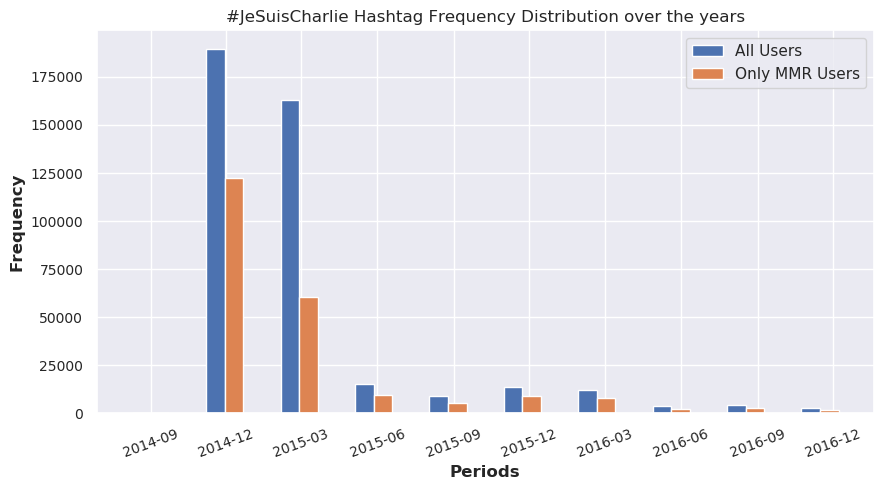

In [321]:
# Plot hashtag frequency distribution
plot_hashtag_frequency_distribution(all_tweets_dates, subgraph_tweets_dates, hashtag_full)

The **#JeSuisCharlie** hashtag doesn't have a really steady frequency distribution over the years in the timeframe we're considering, as it can be seen from the plot above. Indeed, the great majority of the tweets have been published in the first 5 months of 2015, as expected, since the events related to the spread of the hashtags occurred in January 2015. The overall peak has been reached on January 9th, 2015, with **95777** tweets published. The histogram that only considers the MMR users, as expected, follows pretty much the same distribution as the overall one: the peak values are lower but the height difference between the bars seems to be almost identical and the peak value is **61561**, reached on January 10th, 2015.

# 3. Hashtag Subgraph Metric Analysis

## 3.1 Basic Subnetwork Properties
Hereby I show how the basic network properties of $H$ change compared to the full MMR graph, in terms of number of nodes $N$, number of links $L$ and average degree $\langle K \rangle$.

In [9]:
N = hashtag_subgraph.GetNodes()
L = hashtag_subgraph.GetEdges()
K = (2.0*L)/N
print("Nodes of H: %d" %N)
print("Edges of H: %d" %L)
print("Average Degree of H: %.3f" %K)

Nodes of H: 130173
Edges of H: 580518
Average Degree of H: 8.919


| Property | $G$ (SCC) | $H$ (Hashtag Subgraph) | % Relative to $G$
|---|---|---|---|
| **Average Degree $\langle K \rangle$** | 10,127 | 8,919 | -
| **Number of nodes $N$** | 84.510.806 | 130.173 | ~0,15%
| **Number of edges $L$** | 427.935.499 | 580.518 | ~0,13%

## 3.2 Extract Random Graphs
It would be interesting to compare a set of network properties of $H$ with the ones of $M=100$ random subgraphs *of the same size* $N$.

In [6]:
def get_random_subgraphs(graph, M, N):
    return [snap.GetRndSubGraph(graph,N) for _ in range(M)]

In [10]:
%%time
M = 100
random_subgraphs = get_random_subgraphs(graph, M, N)

CPU times: user 8min 42s, sys: 10.4 s, total: 8min 52s
Wall time: 8min 52s


In [11]:
def plot_random_subgraphs_property_distribution(data, hashtag, filename, M, N, labels_dict, rwidth, discrete_values=False, x_ticks_rotation=0, bottom_adjust=None, force_sci=False, y_ticks_step=2, xticks=None, compare_with_hashtag=False, hashtag_value=None, hashtag_text_x_offset=0, hashtag_text_y_value=10):
    #Figure properties
    fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 2]})
    fig.set_size_inches(12,4)
    fig.set_dpi(100)
    
    # Plot histogram
    rnd_label = "Random Subgraphs"
    if discrete_values:
        # Discrete values
        counts, bins, _ = ax1.hist(data, bins=np.arange(max(data)+2)-0.5, align="mid", rwidth=rwidth, label=rnd_label)
        if xticks is None:
            xticks = range(min(data),max(data))
        if hashtag_value is None:
            ax1.set_xlim(min(data)-1,max(data)+1)
        else:
            ax1.set_xlim(min([min(data), hashtag_value])-1,max([max(data),hashtag_value])+1)
        ax1.set_xticks(xticks)
    else:
        # Continuous values
        counts, bins, _ = ax1.hist(data, align="mid", rwidth=rwidth, label=rnd_label)
        ax1.set_xticks(bins)
    if compare_with_hashtag:
        ax1.axvline(x=hashtag_value, label=r"$H$ Subgraph", color='orange', linestyle='--')
        ax1.text(x=hashtag_value+hashtag_text_x_offset, y=hashtag_text_y_value, s=str(hashtag_value), color='orange', weight="bold")
        ax1.legend(loc="upper right")
    
    # Set Histogram y-axis ticks
    ax1.set_yticks(range(int(min(counts)), int(max(counts)), y_ticks_step))
    ax1.xaxis.set_tick_params(rotation=x_ticks_rotation)
    
    # Set Histogram Axes labels and title
    ax1.set_ylabel(labels_dict["y_label"], fontsize=10, fontweight="bold")
    ax1.set_title(labels_dict["hist_title"])
    
    # Disable vertical grid lines
    ax1.xaxis.grid(False)
    
    # Plot Boxplot
    sns.boxplot(data, ax=ax2)
    
    # Set Boxplot axes labels and title
    ax2.set_title(labels_dict["boxplot_title"])
    
    # Set common params
    for ax in (ax1, ax2):
        ax.set_xlabel(labels_dict["x_label"], fontsize=10, fontweight="bold")
        ax.tick_params(labelsize=8)
        if force_sci:
            ax.ticklabel_format(style="sci", axis='x', scilimits=(0,0), useMathText=True)
    
    fig.set_tight_layout(False)
    if not bottom_adjust is None:
        fig.subplots_adjust(bottom=bottom_adjust)
    plt.savefig(os.path.join(pictures_path,hashtag+"_"+filename+".png"))
    plt.show()
    
def plot_property_distribution_comparison(hashtag_subgraph_distribution, random_subgraphs_distribution, labels_dict, linestyle, hashtag, fig_filename, log_axes="both", xticks1=None, xticks2=None):
    x_hashtag = map(lambda x: x[0], hashtag_subgraph_distribution)
    y_hashtag = map(lambda x: x[1], hashtag_subgraph_distribution)
    x_rnd = map(lambda x: x[0], random_subgraphs_distribution)
    y_rnd = map(lambda x: x[1], random_subgraphs_distribution)

    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, squeeze=False)
    fig.set_size_inches(14,10)
    fig.set_dpi(120)
    
    ax1.plot(x_hashtag, y_hashtag, linestyle)
    ax3.plot(x_rnd, y_rnd, linestyle)
    if log_axes == "both":
        ax2.loglog(x_hashtag, y_hashtag, linestyle)
        ax4.loglog(x_rnd, y_rnd, linestyle)
    elif log_axes == "x":
        ax2.semilogx(x_hashtag, y_hashtag, linestyle)
        ax4.semilogx(x_rnd, y_rnd, linestyle)
    elif log_axes == "y":
        ax2.semilogy(x_hashtag, y_hashtag, linestyle)
        ax4.semilogy(x_rnd, y_rnd, linestyle)
    
    # Common properties
    for ax in [ax1, ax2, ax3, ax4]:
        ax.tick_params(labelsize=8)
        ax.set_xlabel(labels_dict["x_label"], fontsize=10, fontweight="bold")
        ax.set_ylabel(labels_dict["y_label"], fontsize=10, fontweight="bold")
    for ax in [ax1, ax2]:
        if not xticks1 is None:
            ax.set_xticks(xticks1)
    for ax in [ax3, ax4]:
        if not xticks2 is None:
            ax.set_xticks(xticks2)

    ax1.set_title(labels_dict["hashtag_normal_title"])
    ax2.set_title(labels_dict["hashtag_log_title"])
    ax3.set_title(labels_dict["random_normal_title"])
    ax4.set_title(labels_dict["random_log_title"])
    
    # Save and show figure
    fig.set_tight_layout(False)
    fig.subplots_adjust(hspace=0.3)
    plt.savefig(os.path.join(pictures_path,hashtag+"_"+fig_filename+".png"))
    plt.show()

## 3.3 Average Degree Comparison
The average degree gives another useful insight closely related to the *network density*. It's worth pointing out that, since the degree is a function of $N$ and $L$, in this case the average degree distribution would be the same as the *edges count distribution* because $N$ is fixed.

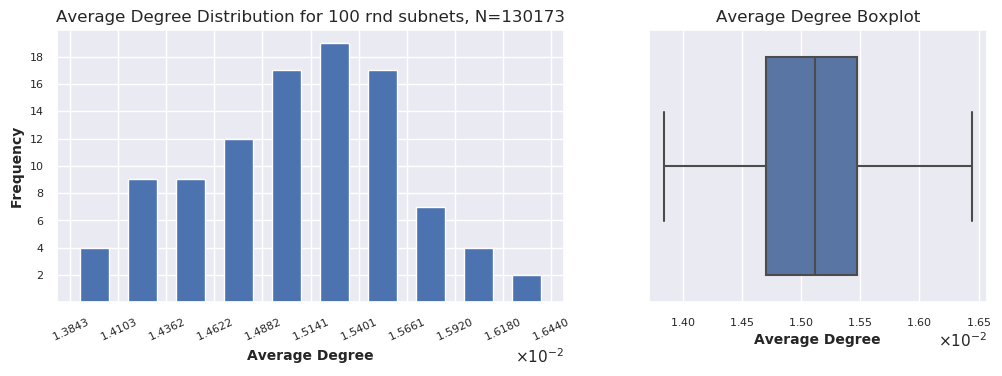

In [362]:
data = [(2.0*rnd.GetEdges())/rnd.GetNodes() for rnd in random_subgraphs]
rwidth = 0.6
x_ticks_rotation = 25
labels_dict = {
    "x_label": "Average Degree",
    "y_label": "Frequency",
    "hist_title": "Average Degree Distribution for %d rnd subnets, N=%d" %(M, N),
    "boxplot_title": "Average Degree Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_average_degree_distribution"
plot_random_subgraphs_property_distribution(data, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, force_sci=True)

Given 100 random subgraphs of same size as $H$, it's clear that $\langle K \rangle _H=8,919$ is shifted by a large offset compared to the mean average degree (**~0,015**) shown in the boxplot above. It would be meaningless to show a vertical line corresponding to the value of $\langle K \rangle _H$, as it would represent a clear outlier.

## 3.4 Median Degree Comparison

In [241]:
def get_median_degree(graph):
    DegToCntV = snap.TIntPrV()
    snap.GetDegCnt(rnd, DegToCntV)
    deg_counter = [(el.GetVal1(), el.GetVal2()) for el in DegToCntV]
    return max(deg_counter, key=lambda x: x[1])

random_median_degrees = [get_median_degree(rnd) for rnd in random_subgraphs]
hashtag_median_degree = get_median_degree(hashtag_subgraph)
print("The median degree for the hashtag network is: %d" %hashtag_median_degree[0])
print("The unique values of median degrees for all random networks are:")
print(list(set(map(lambda x: x[0], random_median_degrees))))

The median degree for the hashtag network is: 0
The unique values of median degrees for all random networks are:
[0]


Apparently the median degree (i.e. the degree that most of the nodes in the network have) of each random subgraph is 0, which means that the random networks have a high number of **isolated nodes** (i.e. *Zero-Degree nodes*) compared to the hashtag subgraph. Let's show more info about the Zero-Degree nodes:

In [236]:
hashtag_zero_deg_nodes = snap.CntDegNodes(hashtag_subgraph, 0)
avg_random_zero_deg_nodes = np.mean([snap.CntDegNodes(rnd, 0) for rnd in random_subgraphs])
print("Hashtag subgraph has %d Zero-Degree nodes (%.2f%% of %d)" %(hashtag_zero_deg_nodes, hashtag_zero_deg_nodes*100.0/N, N))
print("Random subgraphs (on average) have %.3f Zero-Degree nodes (%.2f%% of %d)" %(avg_random_zero_deg_nodes, avg_random_zero_deg_nodes*100.0/N, N))

Hashtag subgraph has 46021 Zero-Degree nodes (35.35% of 130173)
Random subgraphs (on average) have 128331.750 Zero-Degree nodes (98.59% of 130173)


| Property | $H$ | $M=100$ Random Subgraphs
|---|---|---|
| Average Degree $\langle K \rangle$ | 8,919 | ~0,015
| Median Degree | 0 | 0
| Zero-Degree Nodes | 46.021 | 128.331,750
| % Zero-Degree Nodes Relative to $N$ | 35,35% | 98,59%

This provides an alternative perspective to what already found with the average degree distribution above. However, a relatively high number of nodes in $H$ (**35,35%**) are Zero-Degree nodes, therefore its median degree and the median degrees of the random subgraphs are actually the same. By the other side, the mean of the number of Zero-Degree nodes for the random subgraphs is significantly higher (**98,59%** of the total nodes). Therefore, although the median degree actually coincides, there are meaningful differences between the hashtag subgraph and the random ones.

## 3.5 Degree Distribution Comparison
By comparing the degree distribution we would be able to sum up whatever has been said concerning the degree-related properties of the subgraphs.

In [266]:
# Get degree distribution of hashtag subgraph
def get_degree_distribution_hashtag_subgraph(hashtag_subgraph, N):
    DegToCntV_H = snap.TIntPrV()
    snap.GetDegCnt(hashtag_subgraph, DegToCntV_H)
    return [(item.GetVal1(), item.GetVal2() * 1.0 / N) for item in DegToCntV]

# Get mean of degree distributions of random subgraphs
# Get a unique list and do the average of the same degrees frequencies
def get_degree_distribution_random_subgraphs(random_subgraphs, N):
    random_degree_distribution = {} # Save degree values as keys and list of frequencies as values
    for rnd in random_subgraphs:
        DegToCntV_rnd = snap.TIntPrV()
        snap.GetDegCnt(rnd, DegToCntV_rnd)
        for el in DegToCntV_rnd:
            if el.GetVal1() in random_degree_distribution:
                random_degree_distribution[el.GetVal1()].append(el.GetVal2())
            else:
                random_degree_distribution[el.GetVal1()] = [el.GetVal2()]

    # Calculate average value for each degree
    for key in random_degree_distribution:
        random_degree_distribution[key] = np.mean(random_degree_distribution[key])*1.0/N

    # Convert to dict
    return random_degree_distribution.items()

In [267]:
random_degree_distribution = get_degree_distribution_random_subgraphs(random_subgraphs, N)
hashtag_subgraph_degree_distribution = get_degree_distribution_hashtag_subgraph(hashtag_subgraph, N)

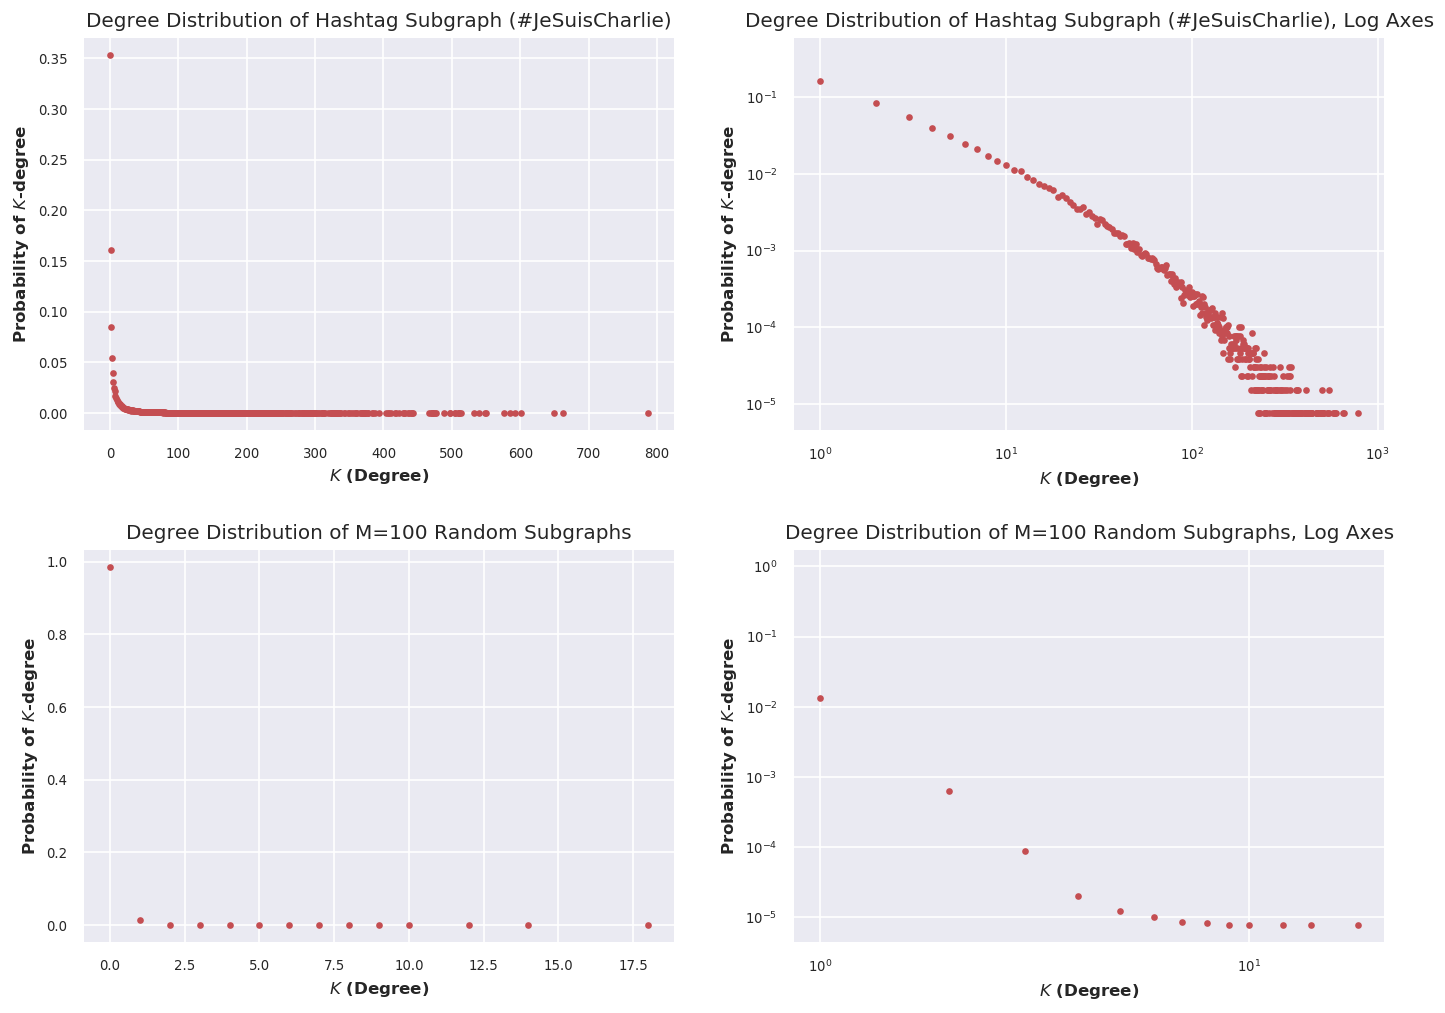

In [380]:
linestyle = "r."
labels_dict = {
    "x_label": r"$K$ (Degree)",
    "y_label": r"Probability of $K$-degree",
    "hashtag_normal_title": "Degree Distribution of Hashtag Subgraph (%s)" %hashtag_full,
    "random_normal_title": "Degree Distribution of M=%d Random Subgraphs" %M,
    "hashtag_log_title": "Degree Distribution of Hashtag Subgraph (%s), Log Axes" %hashtag_full,
    "random_log_title": "Degree Distribution of M=%d Random Subgraphs, Log Axes" %M,
}
plot_property_distribution_comparison(hashtag_subgraph_degree_distribution, random_degree_distribution, labels_dict, linestyle, hashtag_full,"deg_dist_comparison_with_random")

The degree distribution of $H$ basically follows the same trend as $G$, clearly visible with the logarithmic version. It is clear that the degree ranges are very different between $H$ and the random subgraphs. For the former, the maximum degree is close to 800 whereas in the latter it's only 18.

## 3.6 Graph Density Comparison
The density $D$ of a network measures the ratio between the number of *actual connections* and the *potential connections*:

$$D=\frac{L}{L_{max}}$$

Given that, in a network with $N$ nodes, the potential connections in a graph are $L_{max}=\frac{N(N-1)}{2}$, the density is defined as:

$$D=\frac{2L}{N(N-1)}$$

In [338]:
def get_graph_density(graph):
    edges = graph.GetEdges()
    nodes = graph.GetNodes()
    return 2.0*edges/(nodes*(nodes-1))

hashtag_density = get_graph_density(hashtag_subgraph)
random_subgraphs_density = [get_graph_density(rnd) for rnd in random_subgraphs]
print("Hashtag subgraph density: %f" %hashtag_density)

Hashtag subgraph density: 0.000069


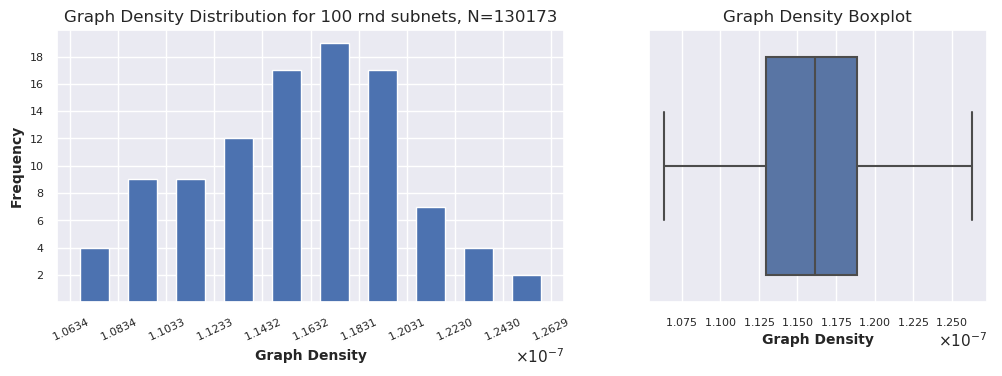

In [361]:
rwidth = 0.6
x_ticks_rotation = 25
labels_dict = {
    "x_label": "Graph Density",
    "y_label": "Frequency",
    "hist_title": "Graph Density Distribution for %d rnd subnets, N=%d" %(M, N),
    "boxplot_title": "Graph Density Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_graph_density_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_density, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, force_sci=True)

In [343]:
print("Average random subgraphs density: %.10f" %np.mean(random_subgraphs_density))

Average random subgraphs density: 0.0000001158


Since *network density* is again a function of the number of nodes and edges, assuming that $N$ is fixed for $H$ and the random subgraphs, it was expected to see the same trend of the average degree for the above distribution. $H$'s density is about **600 times** larger than the mean density of the random subgraphs.

## 3.7 Clustering Coefficient Comparison
The clustering coefficient captures the degree to which the neighbors of a given node link to each other. For a node $i$ with degree $k_i$ the local clustering coefficient is defined as:

$$C_i=\frac{2L_i}{k_i(k_i-1)}$$

where $L_i$ represents the number of links between the $k_i$ neighbors of node $i$. $C_i$ measures the network's local link density: The more densely interconnected the neighborhood of node $i$, the higher is its local clustering coefficient. The degree of clustering of a whole network is captured by the average clustering coefficient, $\langle C \rangle$, representing the average of $C_i$ over all nodes $i=1,\dots,N$.

I'm going to first compare the values of $\langle C \rangle$ between $H$ and the random subgraphs with the standard values distribution histogram. Then, I'll also compare the distribution of the clustering coefficient *by degree*, which would show how the values of the average clust. coefficient for nodes of each degree vary. Finally, the *global clustering coefficient* will also be analyzed.

In [363]:
hashtag_cf_vec = snap.TFltPrV()
hashtag_clustering_coeff = snap.GetClustCf(hashtag_subgraph, hashtag_cf_vec, -1)
print("Hashtag subgraph average clustering coefficient: %.3f" %hashtag_clustering_coeff)

Hashtag subgraph average clustering coefficient: 0.107


In [350]:
# Just calculate average clust. coefficient for each random subgraph and show distribution
random_subgraphs_cf = [snap.GetClustCf(rnd, -1) for rnd in random_subgraphs]

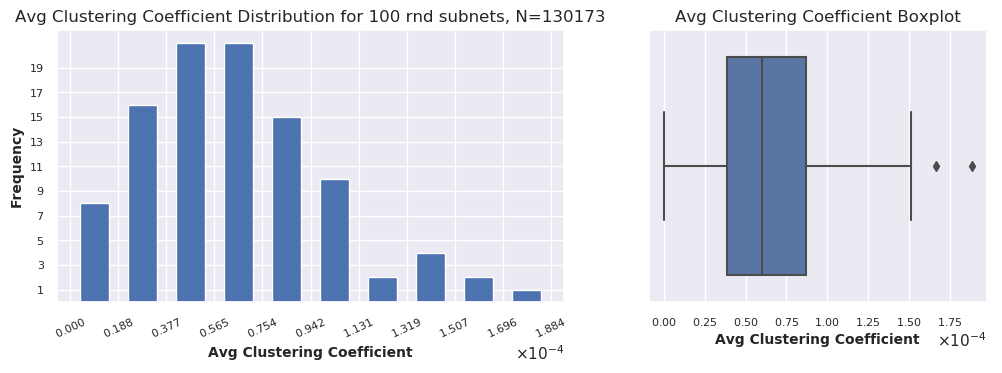

In [360]:
rwidth = 0.6
x_ticks_rotation = 25
labels_dict = {
    "x_label": "Avg Clustering Coefficient",
    "y_label": "Frequency",
    "hist_title": "Avg Clustering Coefficient Distribution for %d rnd subnets, N=%d" %(M, N),
    "boxplot_title": "Avg Clustering Coefficient Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_avg_clust_coeff_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_cf, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, force_sci=True)

The value of the average clustering coefficient of $H$ (**~0,107**) is about 1800 times higher than the mean of the average clustering coefficients of the random subgraphs. Let's see now the distribution of the clustering coefficient *by degree*:

In [367]:
def get_clust_coeff_distribution_hashtag_subgraph(hashtag_subgraph):
    CfVec = snap.TFltPrV()
    snap.GetClustCf(hashtag_subgraph, CfVec, -1)
    return [(item.GetVal1(), item.GetVal2()) for item in CfVec]

def get_degree_distribution_random_subgraphs(random_subgraphs):
    random_clust_coeff_distribution = {}
    for rnd in random_subgraphs:
        CfVec_rnd = snap.TFltPrV()
        snap.GetClustCf(rnd, CfVec_rnd, -1)
        for pair in CfVec_rnd:
            if pair.GetVal1() in random_clust_coeff_distribution:
                random_clust_coeff_distribution[pair.GetVal1()].append(pair.GetVal2())
            else:
                random_clust_coeff_distribution[pair.GetVal1()] = [pair.GetVal2()]

    # Calculate average value for each degree
    for key in random_clust_coeff_distribution:
        random_clust_coeff_distribution[key] = np.mean(random_clust_coeff_distribution[key])

    # Convert to dict
    return random_clust_coeff_distribution.items()

In [368]:
random_avg_clust_coeff_distribution = get_degree_distribution_random_subgraphs(random_subgraphs)
hashtag_avg_clust_coeff_distribution = get_clust_coeff_distribution_hashtag_subgraph(hashtag_subgraph)

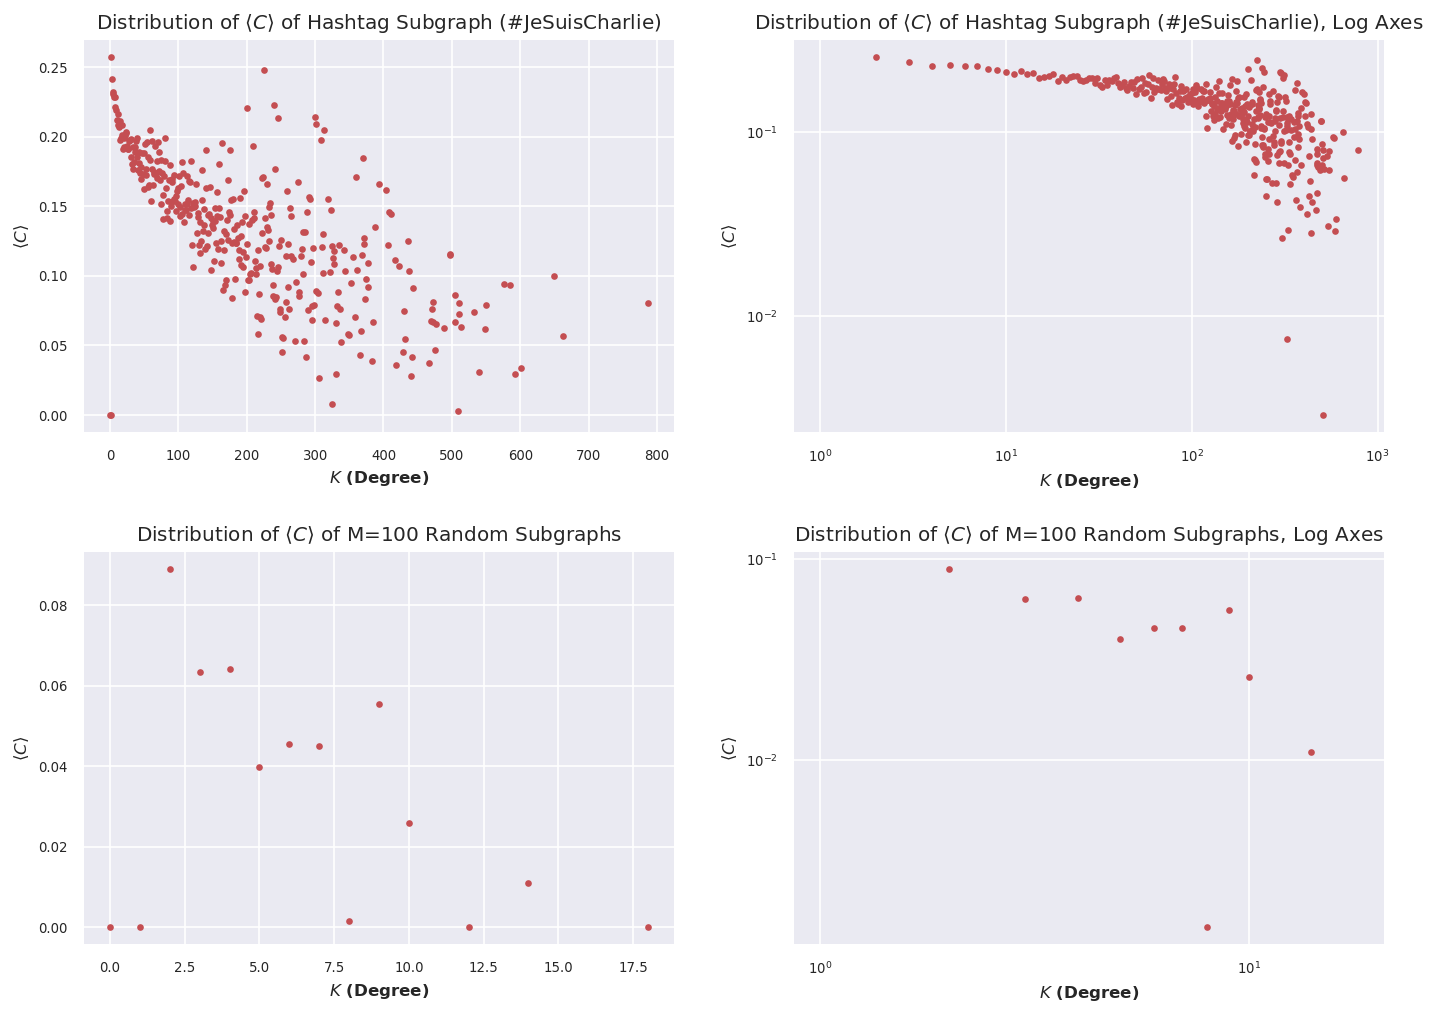

In [381]:
linestyle = "r."
labels_dict = {
    "x_label": r"$K$ (Degree)",
    "y_label": r"$\langle C \rangle$",
    "hashtag_normal_title": r"Distribution of $\langle C \rangle$ of Hashtag Subgraph (%s)" %hashtag_full,
    "random_normal_title": r"Distribution of $\langle C \rangle$ of M=%d Random Subgraphs" %M,
    "hashtag_log_title": r"Distribution of $\langle C \rangle$ of Hashtag Subgraph (%s), Log Axes" %hashtag_full,
    "random_log_title": r"Distribution of $\langle C \rangle$ of M=%d Random Subgraphs, Log Axes" %M,
}
plot_property_distribution_comparison(hashtag_avg_clust_coeff_distribution, random_avg_clust_coeff_distribution, labels_dict, linestyle, hashtag_full,"avg_clust_coeff_comparison_with_random")

Above is the clear difference of the distributions between the hashtag and the random subgraphs. In the first case, we clearly see a general trend for the values of the clustering coefficient for nodes with degree up to $K\simeq100$, then the values are much more random and spread out the more the degree increases. This pattern is even more visible with the logarithmic axes on the right. By the other side, for the random subgraphs identifying a pattern is more or less impossible and not intuitive.

## 3.8 Connected Components Comparison
Let's first compare the size of the **largest connected component** ($MaxCC$) for $H$ and the random subgraphs:

In [12]:
hashtag_max_scc = snap.GetMxScc(hashtag_subgraph)
print("H Largest Connected Component Properties\n%d nodes (%.2f%% of %d total nodes and %.2f%% of %d Non-Zero Degree nodes)" %(hashtag_max_scc.GetNodes(),hashtag_max_scc.GetNodes()*100.0/N, N, hashtag_max_scc.GetNodes()*100.0/snap.CntNonZNodes(hashtag_subgraph), snap.CntNonZNodes(hashtag_subgraph)))
print("%d edges (%.2f%% of %d total edges)" %(hashtag_max_scc.GetEdges(), hashtag_max_scc.GetEdges()*100.0/L, L))

H Largest Connected Component Properties
80374 nodes (61.74% of 130173 total nodes and 95.51% of 84152 Non-Zero Degree nodes)
578202 edges (99.60% of 580518 total edges)


In [13]:
random_subgraphs_cc = [snap.GetMxScc(rnd) for rnd in random_subgraphs]

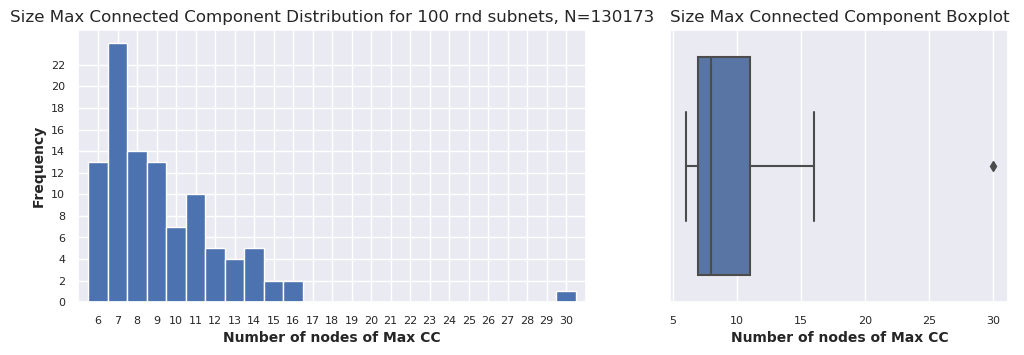

In [229]:
random_subgraphs_cc_nodes = [max_cc.GetNodes() for max_cc in random_subgraphs_cc]
rwidth = 1
xticks = range(min(random_subgraphs_cc_nodes),max(random_subgraphs_cc_nodes)+1)
x_ticks_rotation = 0
labels_dict = {
    "x_label": "Number of nodes of Max CC",
    "y_label": "Frequency",
    "hist_title": "Size Max Connected Component Distribution for %d rnd subnets, N=%d" %(M, N),
    "boxplot_title": "Size Max Connected Component Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_max_cc_nodes_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_cc_nodes, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, discrete_values=True, xticks=xticks)

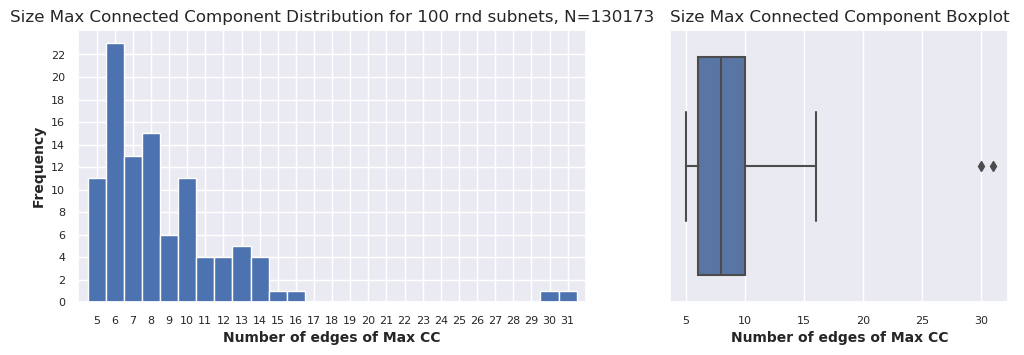

In [230]:
random_subgraphs_cc_edges = [max_cc.GetEdges() for max_cc in random_subgraphs_cc]
rwidth = 1
xticks = range(min(random_subgraphs_cc_edges),max(random_subgraphs_cc_edges)+1)
x_ticks_rotation = 0
labels_dict = {
    "x_label": "Number of edges of Max CC",
    "y_label": "Frequency",
    "hist_title": "Size Max Connected Component Distribution for %d rnd subnets, N=%d" %(M, N),
    "boxplot_title": "Size Max Connected Component Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_max_cc_edges_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_cc_edges, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, discrete_values=True, xticks=xticks)

The plots above show that the sizes of the $MaxCC$s of the random subgraphs, both in terms of number of nodes and edges, are way smaller than the size of $MaxCC_H$. The mean of the number of *nodes* of $MaxCC$ for the $M=100$ random subgraphs is **9,29** ($N_{MaxCC_H}=80374$), whereas the mean of the number of *edges* is **8,73** ($L_{MaxCC_H}=578202$).

Furthermore, $N_{MaxCC_H}$ is equal to **61.74%** of $N_H$ and **95.51%** of the *Non-Zero Degree nodes* of $H$, clearly showing that $H$ is made of a large $MaxCC_H$ that holds the big majority of the nodes, quite many isolated nodes and a small number of minor components.

Next step is to show how many connected components and how they distribute based on their *size*. Again, as I did for the degree distribution and the clustering coefficient, the frequency value for each component size of the random subgraphs is the average of the different frequency values from each subgraph distribution. This will also help to gain more information about the sizes of the other components for both hashtag and random subgraphs.

In [233]:
def get_cc_sizes_distribution_hashtag_subgraph(hashtag_subgraph):
    ComponentDist = snap.TIntPrV()
    snap.GetSccSzCnt(hashtag_subgraph, ComponentDist)
    return [(item.GetVal1(), item.GetVal2()) for item in ComponentDist]

def get_cc_sizes_distribution_random_subgraphs(random_subgraphs):
    random_cc_sizes_distribution = {}
    for rnd in random_subgraphs:
        ComponentDist = snap.TIntPrV()
        snap.GetSccSzCnt(rnd, ComponentDist)
        for pair in ComponentDist:
            if pair.GetVal1() in random_cc_sizes_distribution:
                random_cc_sizes_distribution[pair.GetVal1()].append(pair.GetVal2())
            else:
                random_cc_sizes_distribution[pair.GetVal1()] = [pair.GetVal2()]

    # Calculate average value
    for key in random_cc_sizes_distribution:
        random_cc_sizes_distribution[key] = np.mean(random_cc_sizes_distribution[key])

    # Convert to dict
    return random_cc_sizes_distribution.items()

In [234]:
random_cc_sizes_distribution = get_cc_sizes_distribution_random_subgraphs(random_subgraphs)
hashtag_cc_sizes_distribution = get_cc_sizes_distribution_hashtag_subgraph(hashtag_subgraph)

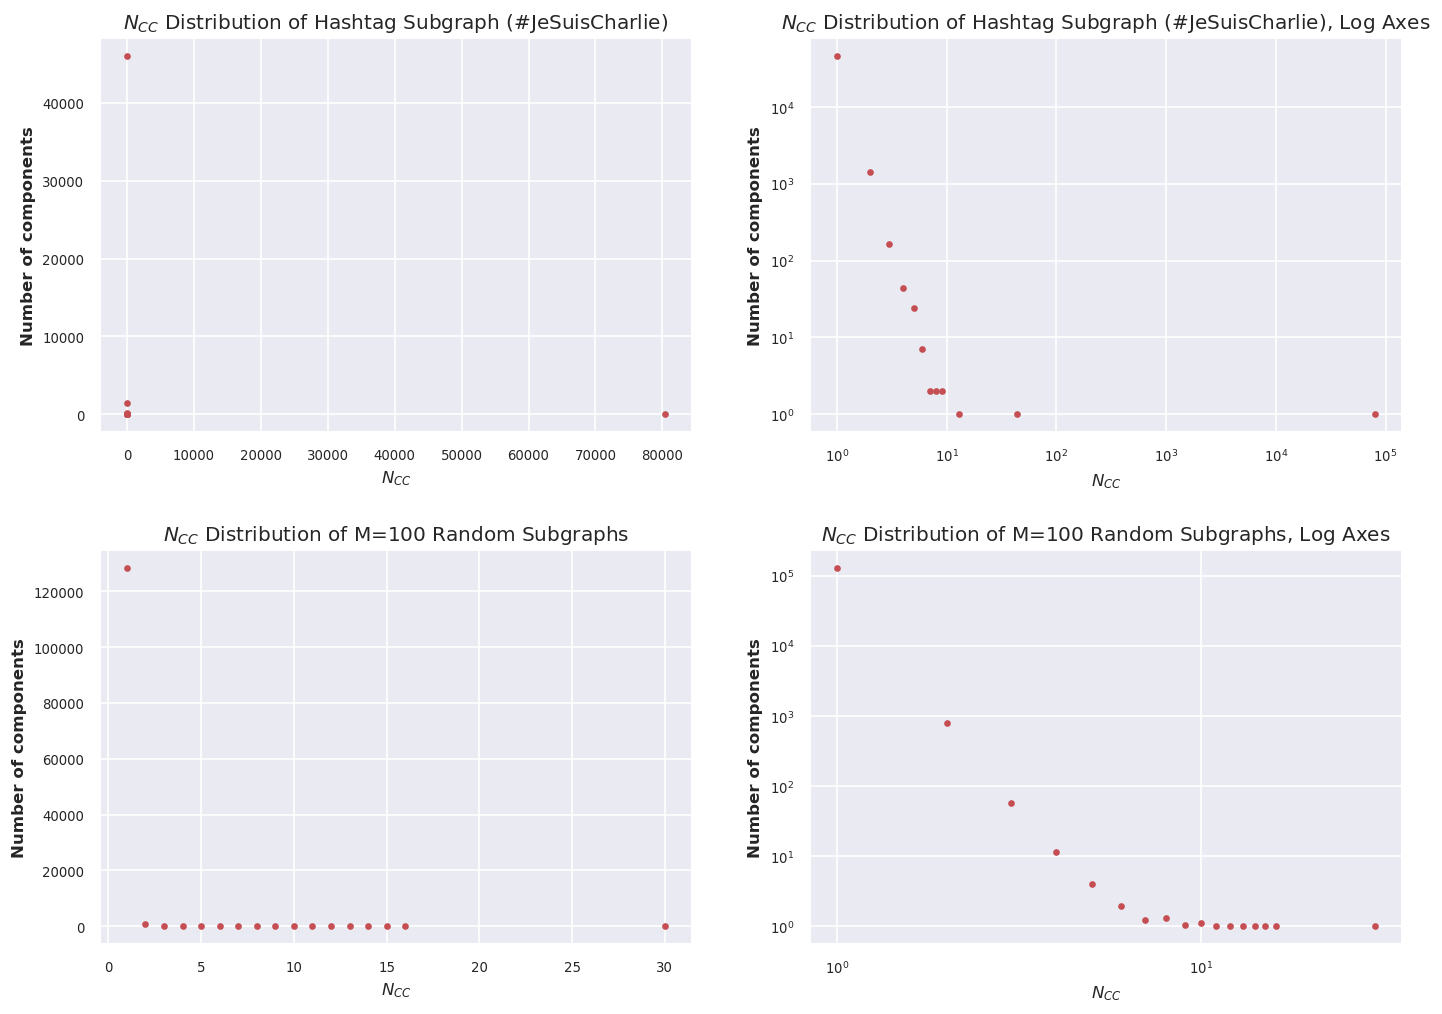

In [266]:
linestyle = "r."
labels_dict = {
    "x_label": r"$N_{CC}$",
    "y_label": "Number of components",
    "hashtag_normal_title": r"$N_{CC}$ Distribution of Hashtag Subgraph (%s)" %hashtag_full,
    "random_normal_title": r"$N_{CC}$ Distribution of M=%d Random Subgraphs" %M,
    "hashtag_log_title": r"$N_{CC}$ Distribution of Hashtag Subgraph (%s), Log Axes" %hashtag_full,
    "random_log_title": r"$N_{CC}$ Distribution of M=%d Random Subgraphs, Log Axes" %M,
}
plot_property_distribution_comparison(hashtag_cc_sizes_distribution, random_cc_sizes_distribution, labels_dict, linestyle, hashtag_full,"cc_sizes_comparison_with_random")

In [236]:
print("%d components + %d isolated" %(sum(map(lambda x: x[1], hashtag_cc_sizes_distribution[1:-1])), hashtag_cc_sizes_distribution[0][1]))

1668 components + 46021 isolated


In [237]:
print("%.2f components + %.2f isolated" %(sum(map(lambda x: x[1], random_cc_sizes_distribution[1:-1])), random_cc_sizes_distribution[0][1]))

880.63 components + 128320.31 isolated


As already mentioned before, the distribution of the connected components sizes of $H$ shows a clear division between the minor components and the largest one: excluding $MaxCC$, there are **1668** total components with size $\geq 2$ and **46021** isolated nodes. For the random graphs, there are **~880,63** total components with size $\geq 2$ and **128320,31** isolated nodes.

Hereby a summary of the connected components analysis:

| Property | $H$ | $M=100$ Random Subgraphs
|---|---|---|
| $N_{MaxCC}$ | 80.374 | ~9,29
| % $N_{MaxCC}$ Relative to $N$ | 61,74% | ~0,007%
| % $N_{MaxCC}$ Relative to $N_{k \gt 0}$ | 95,51% | ~0,5%
| Total components ($N_{CC}\geq 2$) | 1668 | ~880,63

## 3.9 Shortest Path Lengths Comparison
Another relevant key metric for networks is what is commonly used as a measure for **distance**. We're not talking about physical distance, since in networks distance is translated into **path length**, where a path between two nodes $x$ and $y$ is the set of links that may be traversed to reach $y$ from $x$. The length of the path is therefore the number of traversed links. Usually the connotation of path length goes along with **shortest path length**. It would be interesting to get information about the ***average* shortest path length** $\langle d \rangle$, the **distribution of the shortest path lengths** and the **network diameter** $d_{max}$ (the longest shortest path in a graph, or the distance between the two furthest nodes). Along with $d_{max}$, usually there's an additional metric related to shortest path lengths known as **effective diameter** $d_{eff}$: the 90-th percentile of the distribution of shortest path lengths, or in other words, the minimal distance such that 90% of paths are at most at that distance from each other.

In order to consider meaningful results, I may restrict this comparison to the largest connected component $MaxCC$ of $H$ and the random subgraphs.

$\langle d \rangle$ is the fraction between the sum of all-pairs shortest-path length of the graph and the total number of all shortest paths that exist in the graph. Assuming that we're only working with connected components, the latter is always $N(N-1)$:

$$\langle d \rangle = \frac{\sum_{i,j}^N d_{i,j}}{N(N-1)}$$

In [153]:
# Functions used to calculate average shortest path length, diameter and shortest path lengths distribution for hashtag and random subgraphs
def calculate_shortest_path_lengths_distribution(graph, hashtag):
    start = time.time()
    print("Calculating shortest path lengths distribution...")
    snap.PlotShortPathDistr(graph, hashtag+"_shortestPathLengthsDist", "Shortest Path Lengths Distribution")
    end = time.time()
    print("Completed in: %s" %timedelta(seconds=(int(end-start))))
    
def calculate_shortest_path_lengths_distribution_random(graph, hashtag, rnd_index):
    snap.PlotShortPathDistr(graph,hashtag+"_random"+str(rnd_index)+"_shortestPathLengthsDist", "Shortest Path Lengths Distribution")

def read_aspl_diam(filename):
    with open("temp_results/diam."+filename+"_shortestPathLengthsDist.tab") as fin:
        content = fin.read()
        aspl = float(re.search(r'avg:(\d+\.?\d*)', content).group(1))
        eff_diam = float(re.search(r'eff:(\d+\.?\d*)', content).group(1))
        max_diam = int(re.search(r'max:(\d+\.?\d*)', content).group(1))
    return aspl,eff_diam,max_diam
    
def read_shortest_path_lengths_distribution(filename):
    return pd.read_csv("temp_results/diam."+filename+"_shortestPathLengthsDist.tab",sep="\t",skiprows=4,header=None, names=["Hops","Shortest Paths"], dtype={"Hops": np.uint32, "Shortest Paths": np.uint32})

I got these results for $H$:

In [154]:
hashtag_aspl, hashtag_eff_diam, hashtag_max_diam = read_aspl_diam(hashtag)
print("Average shortest path length: %.2f\nEffective Diameter: %.2f\nMax Diameter: %d" %(hashtag_aspl, hashtag_eff_diam, hashtag_max_diam))

Average shortest path length: 5.67
Effective Diameter: 7.23
Max Diameter: 19


Calculating these properties for the random graphs should be significantly quicker, due to the size of their largest connected components compared to $H$.

In [147]:
# Compute and save results to file by default 
for i,rnd in enumerate(random_subgraphs_cc):
    calculate_shortest_path_lengths_distribution_random(rnd, hashtag, i)
    if i%10==0 and i!=0:
        print("Processed %d random subgraphs..." %i)
print("Done!")

In [155]:
def get_aspl_diam_random_subgraphs(random_subgraphs_cc, hashtag):
    aspl = []
    eff_diam = []
    max_diam = []
    for i,_ in enumerate(random_subgraphs_cc):
        rnd_aspl, rnd_eff_diam, rnd_max_diam = read_aspl_diam(hashtag+"_random"+str(i))
        aspl.append(rnd_aspl)
        eff_diam.append(rnd_eff_diam)
        max_diam.append(rnd_max_diam)
    return aspl, eff_diam, max_diam

def get_spl_distribution_random_subgraphs(random_subgraphs_cc, hashtag):
    random_spl_distribution = {}
    for i,_ in enumerate(random_subgraphs_cc):
        # Read back results in a Pandas Dataframe
        df = read_shortest_path_lengths_distribution(hashtag+"_random"+str(i))
        for _,r in df.iterrows():
            if r["Hops"] in random_spl_distribution:
                random_spl_distribution[r["Hops"]].append(r["Shortest Paths"])
            else:
                random_spl_distribution[r["Hops"]] = [r["Shortest Paths"]]

    # Calculate average value
    for key in random_spl_distribution:
        random_spl_distribution[key] = np.mean(random_spl_distribution[key])

    # Convert to dict
    return random_spl_distribution.items()

In [165]:
# Read back results
random_subgraphs_spl_distribution = get_spl_distribution_random_subgraphs(random_subgraphs_cc, hashtag)
random_subgraphs_aspl, random_subgraphs_eff_diam, random_subgraphs_max_diam = get_aspl_diam_random_subgraphs(random_subgraphs_cc, hashtag)

Let's now plot the distribution of the $\langle d \rangle$, $d_{eff}$ and $d_{max}$ for the random subgraphs and compare with the values obtained for $H$:

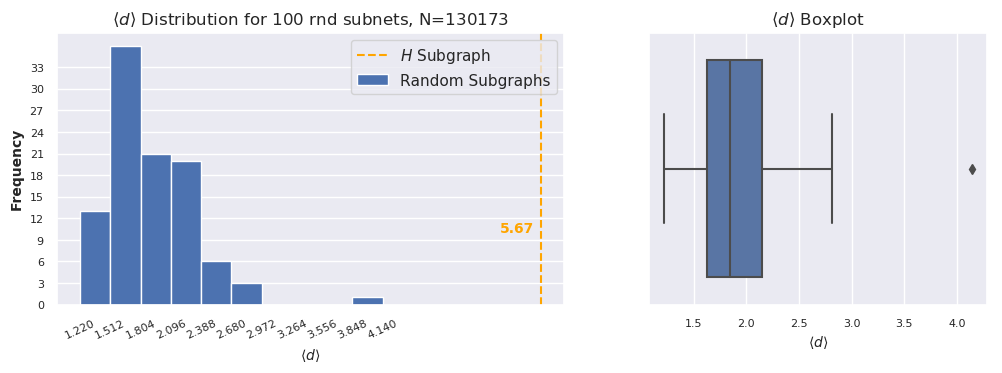

In [331]:
hashtag_text_x_offset = -0.4
rwidth = 1
y_ticks_step = 3
x_ticks_rotation = 25
labels_dict = {
    "x_label": r"$\langle d \rangle$",
    "y_label": "Frequency",
    "hist_title": r"$\langle d \rangle$ Distribution for %d rnd subnets, N=%d" %(M, N),
    "boxplot_title": r"$\langle d \rangle$ Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_aspl_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_aspl, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, y_ticks_step=y_ticks_step, compare_with_hashtag=True, hashtag_value=hashtag_aspl, hashtag_text_x_offset=hashtag_text_x_offset)

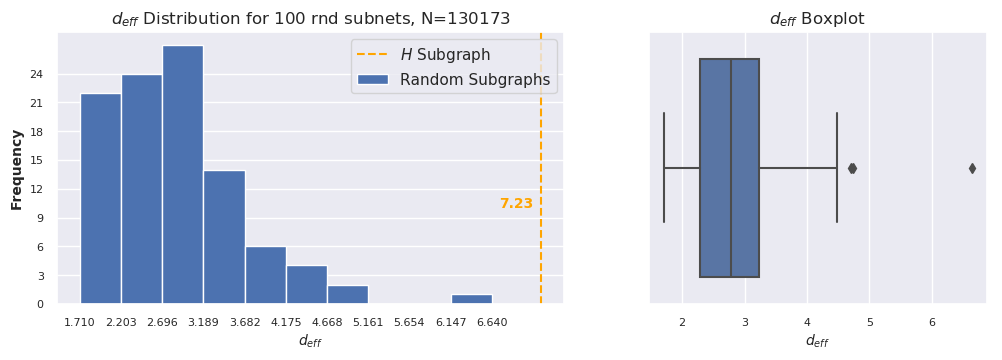

In [334]:
hashtag_text_x_offset = -0.5
rwidth = 1
y_ticks_step = 3
x_ticks_rotation = 0
labels_dict = {
    "x_label": r"$d_{eff}$",
    "y_label": "Frequency",
    "hist_title": r"$d_{eff}$ Distribution for %d rnd subnets, N=%d" %(M, N),
    "boxplot_title": r"$d_{eff}$ Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_eff_diam_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_eff_diam, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, y_ticks_step=y_ticks_step, compare_with_hashtag=True, hashtag_value=hashtag_eff_diam, hashtag_text_x_offset=hashtag_text_x_offset)

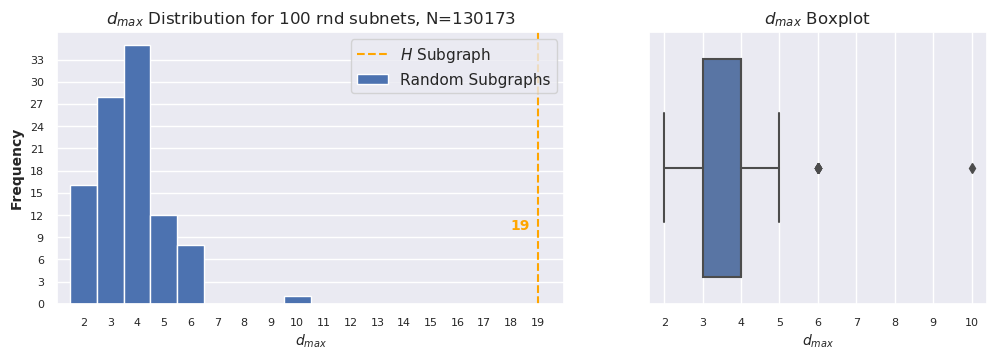

In [336]:
hashtag_text_x_offset = -1
rwidth = 1
y_ticks_step = 3
x_ticks_rotation = 0
xticks = range(min(random_subgraphs_max_diam),hashtag_max_diam+1)
labels_dict = {
    "x_label": r"$d_{max}$",
    "y_label": "Frequency",
    "hist_title": r"$d_{max}$ Distribution for %d rnd subnets, N=%d" %(M, N),
    "boxplot_title": r"$d_{max}$ Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_max_diam_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs_max_diam, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, y_ticks_step=y_ticks_step, discrete_values=True, xticks=xticks, compare_with_hashtag=True, hashtag_value=hashtag_max_diam, hashtag_text_x_offset=hashtag_text_x_offset)

It's quite clear again that $H$ and the random subgraphs have not negligible differences in terms of path lengths. For the random subgraphs, only a few outliers had values of $\langle d \rangle$, $d_{eff}$ and $d_{max}$ that got closer to the same values for $H$, while the boxplots show that most of the observations are concentrated around mean values that are way lower. The table below summarizes these differences. In particular, it's interesting to notice that for the random subgraphs $d_{eff}$, on average, is quite similar to $d_{max}$: this means that most of the paths existing in the subgraphs (including the path between the two furthest nodes) need only a few hops in order to be fully traversed. Due to the nature of the subgraphs in terms of component sizes, it makes sense to have a high similarity between these metrics. In the case of $H$, we identify a quite low gap between $\langle d \rangle$ and $d_{eff}$, meaning that there a few paths that behave as *outliers* and are far away from each other.

| Property | $H$ | $M=100$ Random Subgraphs
|---|---|---|
| $\langle d \rangle$ | 5,67 | ~1,917
| $d_{eff}$ | 7,23 | ~2,843
| $d_{max}$ | 19 | ~3,740

Finally, the distribution of the shortest path lengths will provide an additional perspective to what has just been said: 

In [258]:
hashtag_spl_distribution = read_shortest_path_lengths_distribution(hashtag)
hashtag_spl_distribution = zip(list(hashtag_spl_distribution["Hops"]), list(hashtag_spl_distribution["Shortest Paths"]))

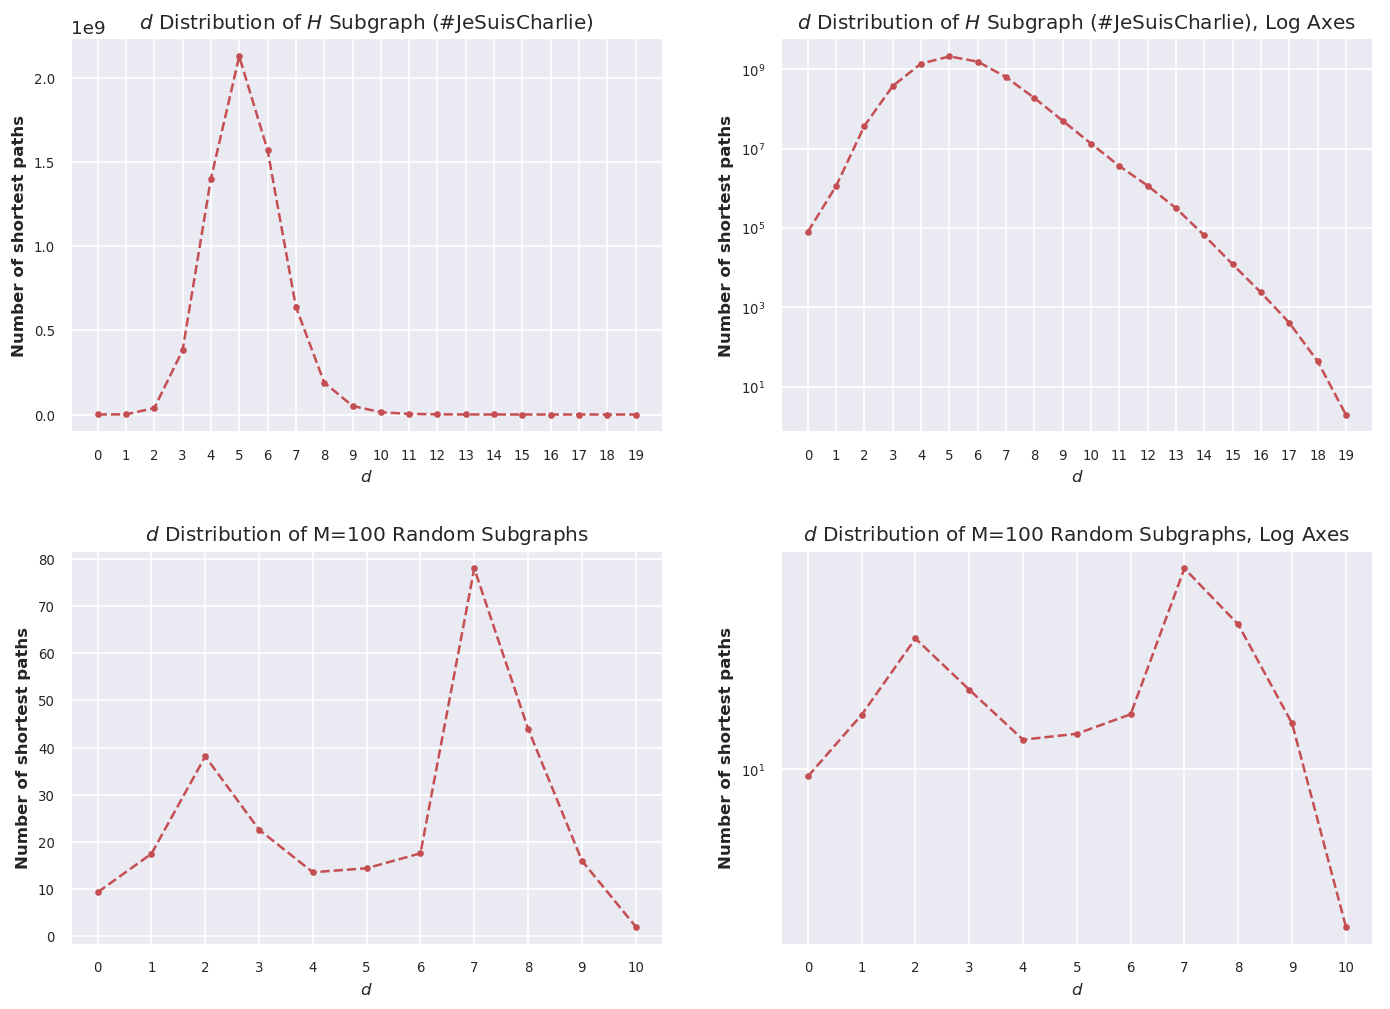

In [337]:
linestyle = "r.--"
xticks1 = range(min(map(lambda x: x[0], hashtag_spl_distribution)), max(map(lambda x: x[0], hashtag_spl_distribution))+1)
xticks2 = range(min(map(lambda x: x[0], random_spl_distribution)), max(map(lambda x: x[0], random_spl_distribution))+1)
labels_dict = {
    "x_label": r"$d$",
    "y_label": "Number of shortest paths",
    "hashtag_normal_title": r"$d$ Distribution of $H$ Subgraph (%s)" %hashtag_full,
    "random_normal_title": r"$d$ Distribution of M=%d Random Subgraphs" %M,
    "hashtag_log_title": r"$d$ Distribution of $H$ Subgraph (%s), Log Axes" %hashtag_full,
    "random_log_title": r"$d$ Distribution of M=%d Random Subgraphs, Log Axes" %M,
}
plot_property_distribution_comparison(hashtag_spl_distribution, random_spl_distribution, labels_dict, linestyle, hashtag_full,"spl_comparison_with_random", log_axes="y", xticks1=xticks1, xticks2=xticks2)

In $H$, most of the shortest paths have length $d=5$, and a large number of paths have length $3\leq d \leq 8$. Yet, the plot with the logarithmic y-axis shows that, the more the number of hops increase, the more the amount of shortest paths with such number of hops rapidly decreases. Although the maximum value of $d=19$ is quite singular, there is still a relatively high number of paths for $d\gt 8$

By the other side, the behavior of $d$ for the random subgraphs is quite unsteady: on average, it highlights the presence of a relatively high number of paths with length $d=\{2,7,9\}$, but, unlike it happens for $H$, the differences between the different random subgraphs are strong and it's impossible to generate a nice curve that indicates a reasonable trend.

## 3.10 Average Centrality Comparison
I may start computing relevant nodes rankings based on well known criteria in network science. **Centrality** provides a measure of node rankings which is helpful to identify the most important nodes in a network. But what does *important* mean? In order to avoid any ambiguity, there are different measures that adapt to different contexts when it comes to nodes *importance*. Since our network is fundamentally a social network, I'll try in this section to identify the most influential people. Usually, based on the nature of the network, different notions of centrality give different choices of the most central nodes. A ranking only orders nodes by importance, it does not quantify the difference in importance between different levels of the ranking. Furthermore, only the top ranked nodes actually reflect a meaningful result, whereas for the biggest majority of the other nodes the rankings may be meaningless.

For sake of comparison between $H$ and the random subgraphs, I may compare the values of for the **average centrality** for each of the centrality types that follow.

In [43]:
def get_hashtag_centrality(hashtag, centrality_type, filename):
    hashtag_centrality = pd.read_csv("temp_results/"+hashtag+"_"+filename+".csv", dtype={"Node": np.uint32, centrality_type: np.float32})
    hashtag_centrality.sort_values(by=centrality_type, inplace=True,ascending=False)
    hashtag_avg_centrality = np.mean(hashtag_centrality[centrality_type])
    print("H Average "+centrality_type+" is %f" %hashtag_avg_centrality)
    return hashtag_centrality, hashtag_avg_centrality

def show_top_centrality_scores(top_k, hashtag_centrality):
    node_ids = [int(el) for el in list(hashtag_centrality["Node"])[:top_k]]
    id_to_username_dict = get_multiple_usernames(node_ids)
    temp_df = pd.DataFrame(id_to_username_dict.items(), columns=["Node","Username"])
    cast_df_to_original_types(temp_df, ["Node","Username"], {"Node": np.uint32, "Username": np.str})
    hashtag_centrality = temp_df.merge(hashtag_centrality, on="Node")
    hashtag_centrality.sort_values(by=hashtag_centrality.columns[2], inplace=True,ascending=False)
    display(hashtag_centrality)
    return hashtag_centrality

### 3.10.1 Closeness Centrality
This measure is calculated as the reciprocal of the farness centrality, which is the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus, the more central a node is, the closer it is to all other nodes. The normalized version represents the average length of the shortest paths instead of their sum:

$C(i)=\frac{N}{\sum\nolimits_{j}d_{i,j}}$

where $d_{i,j}$ is the distance between nodes $i$ and $j$.

In [40]:
hashtag_closeness_centrality, hashtag_avg_closeness_centrality = get_hashtag_centrality(hashtag, "Closeness Centrality", "closeness_centrality")

H Average Closeness Centrality is 0.195104


In [414]:
def get_avg_closeness_centrality_random_subgraphs(random_subgraphs_cc):
    avg_closeness_centrality = []
    for rnd in random_subgraphs_cc:
        closeness_centrality_scores = []
        for node in rnd.Nodes():
            score = snap.GetClosenessCentr(rnd, node.GetId())
            if score == 0:
                continue
            closeness_centrality_scores.append(score)
        avg_closeness_centrality.append(np.mean(closeness_centrality_scores))
    return avg_closeness_centrality

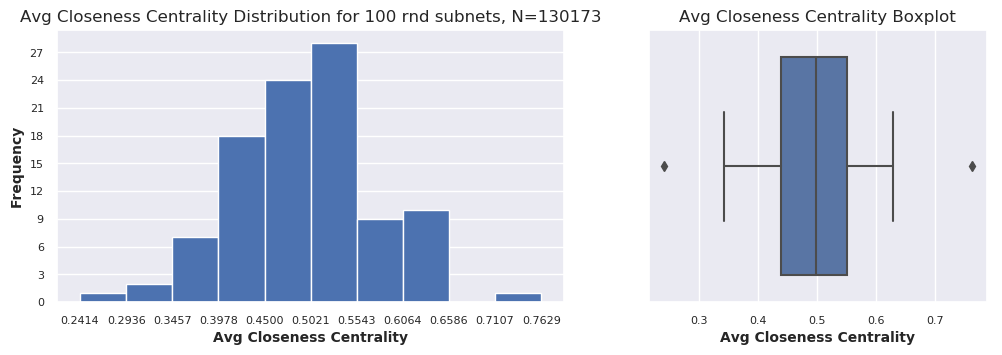

In [415]:
random_subgraphs_avg_closeness_centrality = get_avg_closeness_centrality_random_subgraphs(random_subgraphs_cc)
rwidth = 1
x_ticks_rotation = 0
labels_dict = {
    "x_label": "Avg Closeness Centrality",
    "y_label": "Frequency",
    "hist_title": "Avg Closeness Centrality Distribution for %d rnd subnets, N=%d" %(M, N),
    "boxplot_title": "Avg Closeness Centrality Boxplot"
}
bottom_adjust = 0.2
y_ticks_step = 3
filename = "random_subgraphs_avg_closeness_centrality"
plot_random_subgraphs_property_distribution(random_subgraphs_avg_closeness_centrality, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, y_ticks_step=y_ticks_step)

In [44]:
hashtag_closeness_centrality_top = show_top_centrality_scores(20, hashtag_closeness_centrality)

,Node,Username,Closeness Centrality
15,732552,senateur61,0.282
1,64349156,markgkirshner,0.280
18,23278,kitty77000,0.279
9,435418,alkanz,0.279
10,567768,stanleycohenlaw,0.278
4,27806428,paoloigna1,0.276
16,270892,samuellaurent,0.276
6,1163895,louisemensch,0.275
2,3058999,riwired,0.275
3,921586,magdalakoff,0.275


### 3.10.2 Betweenness Centrality
For every pair of nodes in a connected graph, there exists at least one shortest path between the nodes such that the number of edges that the path passes through is *minimized*. The betweenness centrality for each node is the number of these shortest paths that pass through the vertex. **Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes**. In a social network, it provides a measure for quantifying the control of a human on the communication between other humans. Therefore, nodes that have a high probability to occur on a randomly chosen shortest path between two randomly chosen nodes have a high betweenness.

Betweenness centrality $g(v)$ *for a node $v$* may be obtained by summing, for every two nodes $s$ and $t$, the fraction between $\sigma_{s,t}(v)$, the number of shortest paths from $s$ to $t$ *that pass through $v$*, and $\sigma_{s,t}$, the total number of shortest paths from $s$ to $t$:

$$g(v)=\sum_{s\ne t\ne v}\frac{\sigma_{s,t}(v)}{\sigma_{s,t}}$$

Unfortunately, SNAP.Py only comes with a built-in function that calculates betweenness centrality for both nodes and edges, significantly increasing complexity and execution times. Running the function on $MaxCC_H$ took *6 hours* to complete!

In [25]:
hashtag_betweenness_centrality, hashtag_avg_betweenness_centrality = get_hashtag_centrality(hashtag, "Betweenness Centrality", "betweenness_centrality_nodes")

H Average Betweenness Centrality is 230012.515625


In [365]:
def get_avg_nodes_betweenness_centrality_random_subgraphs(random_subgraphs_cc):
    avg_betweenness_centrality = []
    for rnd in random_subgraphs_cc:
        Nodes = snap.TIntFltH()
        Edges = snap.TIntPrFltH()
        snap.GetBetweennessCentr(rnd, Nodes, Edges, 1.0)
        betwenness_centrality_values = [Nodes[node] for node in Nodes if Nodes[node] != 0]
        avg_betweenness_centrality.append(np.mean(betwenness_centrality_values))
    return avg_betweenness_centrality

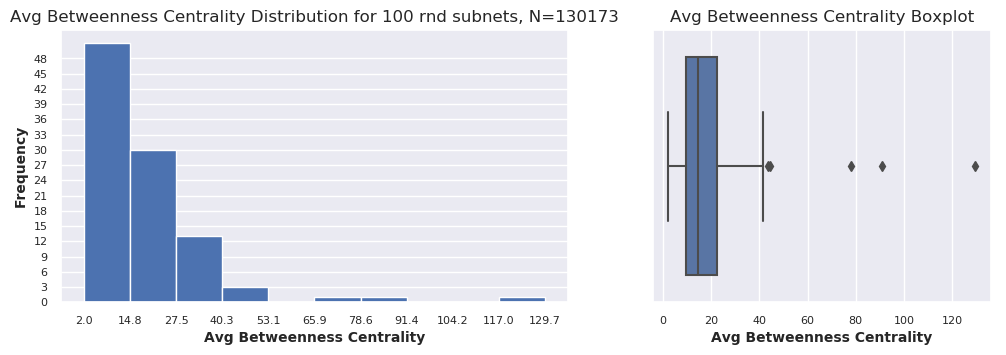

In [370]:
random_subgraphs_avg_nodes_betwenness_centrality = get_avg_nodes_betweenness_centrality_random_subgraphs(random_subgraphs_cc)
rwidth = 1
x_ticks_rotation = 0
labels_dict = {
    "x_label": "Avg Betweenness Centrality",
    "y_label": "Frequency",
    "hist_title": "Avg Betweenness Centrality Distribution for %d rnd subnets, N=%d" %(M, N),
    "boxplot_title": "Avg Betweenness Centrality Boxplot"
}
bottom_adjust = 0.2
y_ticks_step = 3
filename = "random_subgraphs_avg_nodes_betweenness_centrality"
plot_random_subgraphs_property_distribution(random_subgraphs_avg_nodes_betwenness_centrality, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, y_ticks_step=y_ticks_step)

Let's also show who are the top 20 nodes with highest betweenness centrality in $H$. This would point out who are the most influential usernames. 

In [45]:
hashtag_betweenness_centrality_top = show_top_centrality_scores(20, hashtag_betweenness_centrality)

,Node,Username,Betweenness Centrality
12,50544145,sncf,5.019e+07
5,27806428,paoloigna1,4.878e+07
7,1163895,louisemensch,4.477e+07
15,732552,senateur61,3.622e+07
1,64349156,markgkirshner,3.317e+07
10,368890,alphabetsuccess,3.058e+07
0,142344,marcelsel,3.003e+07
9,435418,alkanz,2.917e+07
18,295114,monaeltahawy,2.829e+07
4,27782756,nikosaliagas,2.681e+07


### 3.10.3 Eigenvector Centrality
Eigenvector Centrality provides a measure of the influence of a node in a network. Relative scores are assigned to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores. Given a node $v$ and its set if neighbors $M(v)$ and a constant value $\lambda$, its eigenvector centrality score is given by:

$$eigen(v)=\frac{1}{\lambda}\sum_{t\in M(v)}eigen(t)=\frac{1}{\lambda}\sum_{t\in G}a_{t,v}eigen(t)$$

If we consider the adjacency matrix $A$ where each entry $a_{i,j} = 1$ if $i$ and $j$ are connected, $0$ otherwise, this may be re-written in eigenvector equation:

$$\mathbf{Ax}=\lambda\mathbf{x}$$

Since there will be many different eigenvalues $\lambda$  for which a non-zero eigenvector solution exists, but all the entries in the eigenvector have to be non-negative, the greatest eigenvalue is then chosen and the $v^{th}$ component of the related eigenvector then gives the relative centrality score of the vertex $v$ in the network.

In [27]:
hashtag_eigenvector_centrality, hashtag_avg_eigenvector_centrality = get_hashtag_centrality(hashtag, "Eigenvector Centrality", "eigenvector_centrality")

H Average Eigenvector Centrality is 0.000484


In [14]:
def get_avg_eigenvector_centrality_random_subgraphs(random_subgraphs_cc):
    avg_eigenvector_centrality = []
    for rnd in random_subgraphs_cc:
        NIdEigenH = snap.TIntFltH()
        snap.GetEigenVectorCentr(rnd, NIdEigenH)
        eigenvector_centrality_values = [NIdEigenH[node] for node in NIdEigenH if NIdEigenH[node] != 0]
        avg_eigenvector_centrality.append(np.mean(eigenvector_centrality_values))
    return avg_eigenvector_centrality

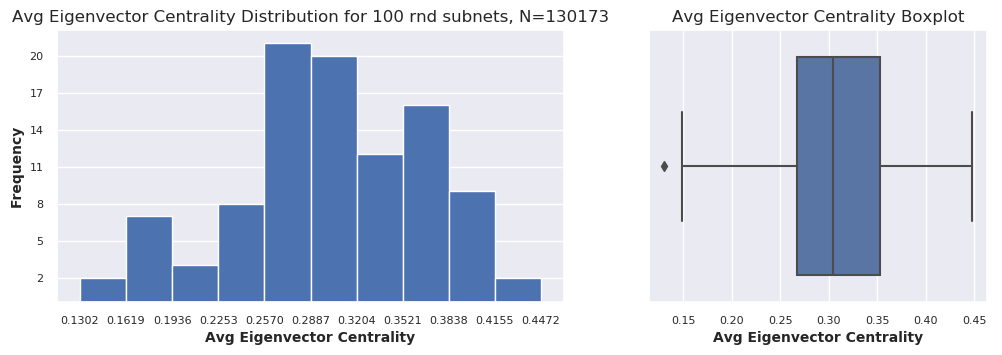

In [30]:
random_subgraphs_avg_eigenvector_centrality = get_avg_eigenvector_centrality_random_subgraphs(random_subgraphs_cc)
rwidth = 1
x_ticks_rotation = 0
labels_dict = {
    "x_label": "Avg Eigenvector Centrality",
    "y_label": "Frequency",
    "hist_title": "Avg Eigenvector Centrality Distribution for %d rnd subnets, N=%d" %(M, N),
    "boxplot_title": "Avg Eigenvector Centrality Boxplot"
}
bottom_adjust = 0.2
y_ticks_step = 3
filename = "random_subgraphs_avg_eigenvector_centrality"
plot_random_subgraphs_property_distribution(random_subgraphs_avg_eigenvector_centrality, hashtag_full, filename, M, N, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust, y_ticks_step=y_ticks_step)

In [46]:
hashtag_eigenvector_centrality_top = show_top_centrality_scores(20, hashtag_eigenvector_centrality)

,Node,Username,Eigenvector Centrality
19,358,johnpalissy,0.138
1,682186,jstlangevin,0.124
17,969601,elisahk92,0.107
7,1519552,ptdarcole,0.106
18,37630618,danielpilotte,0.098
3,243826,dominiquelunel,0.097
14,670349,rosesouslapluie,0.094
16,27918429,marcelinof54,0.094
5,3810624,popoche69008,0.093
12,329683,lacpure,0.090


### 3.10.4 Centrality Results Summary
| Centrality (Average) | $H$ | $M=100$ Random Subgraphs
|---|---|---|
| Betweenness | 230012,516 | ~19,141
| Closeness | 0,195104 | ~0.497
| Eigenvector | 0,000484 | ~0,302043

*Explain final results of centrality scores.*

In [54]:
hashtag_closeness_centrality_top.merge(hashtag_betweenness_centrality_top)

,Node,Username,Closeness Centrality,Betweenness Centrality
0,732552,senateur61,0.282,3.622e+07
1,64349156,markgkirshner,0.280,3.317e+07
2,23278,kitty77000,0.279,2.073e+07
3,435418,alkanz,0.279,2.917e+07
4,567768,stanleycohenlaw,0.278,2.005e+07
5,27806428,paoloigna1,0.276,4.878e+07
6,270892,samuellaurent,0.276,2.454e+07
7,1163895,louisemensch,0.275,4.477e+07
8,3058999,riwired,0.275,1.891e+07
9,872388,jeromegodefroy,0.274,1.927e+07


In [55]:
hashtag_closeness_centrality_top.merge(hashtag_eigenvector_centrality_top)

,Node,Username,Closeness Centrality,Eigenvector Centrality
0,37202125,abergeracberger,0.274,0.080
1,358,johnpalissy,0.274,0.138
2,682186,jstlangevin,0.274,0.124
